**Framing the problem**

In this notebook using the UCI bike rental dataset, we will try to achieve the following -


*   Predicting bike rental demand
*   Understanding the factors that influence bike demand
*   Identify outliers






**Gathering Data**

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"abhinavraj9999","key":"1d46748cfd67e62e6e0225af5c6bc77c"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ahsan81/superstore-marketing-campaign-dataset

!unzip superstore-marketing-campaign-dataset.zip
!ls



mkdir: cannot create directory ‘/root/.kaggle’: File exists
superstore-marketing-campaign-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  superstore-marketing-campaign-dataset.zip
replace superstore_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 'kaggle (1).json'   superstore_data.csv
 kaggle.json	    superstore-marketing-campaign-dataset.zip
 sample_data


In [4]:
df = pd.read_csv('superstore_data.csv')
pd.set_option('display.max_columns',None)

**PreProcessing**

In [5]:
df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0


In [6]:
df.isna().sum()

Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

In [7]:
df.drop("Id",axis = 1,inplace=True)
df.dropna(inplace=True)

In [8]:
for col in df.columns:
  if df[col].nunique() <= 8:
    print(f'{col}: {df[col].unique()}')
  else:
    print(f'{col}: {df[col].unique()[:9]}')

Year_Birth: [1970 1961 1958 1967 1989 1954 1947 1979 1959]
Education: ['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
Marital_Status: ['Divorced' 'Single' 'Married' 'Together' 'Widow' 'YOLO' 'Alone' 'Absurd']
Income: [84835. 57091. 67267. 32474. 21474. 71691. 63564. 44931. 65324.]
Kidhome: [0 1 2]
Teenhome: [0 1 2]
Dt_Customer: ['6/16/2014' '6/15/2014' '5/13/2014' '11/5/2014' '8/4/2014' '3/17/2014'
 '1/29/2014' '1/18/2014' '11/1/2014']
Recency: [0 1 2 3 4 5 6 7 8]
MntWines: [189 464 134  10   6 336 769  78 384]
MntFruits: [104   5  11   0  16 130  80  26   4]
MntMeatProducts: [379  64  59   1  24 411 252  11 102]
MntFishProducts: [111   7  15   0  11 240  21  73  80]
MntSweetProducts: [189   0   2  32  34  98  13  20  16]
MntGoldProds: [218  37  30   0  34  43  65   7   5]
NumDealsPurchases: [ 1  2  3  0  4 12  7  5  6]
NumWebPurchases: [ 4  7  3  1 10  2  6  5 25]
NumCatalogPurchases: [ 4  3  2  0  1  7 10  6  8]
NumStorePurchases: [ 6  7  5  2  3  9 10  0  8]
NumWebVisitsMonth: [1 5

In [9]:
min(df['Dt_Customer'])

'1/1/2013'

In [10]:
dt = 2013
df['Age'] = dt - df['Year_Birth']

In [11]:
df['Total_Spent'] = df['MntWines']+ df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']
df['Children'] = df['Kidhome'] + df['Teenhome']
df['Married'] = df['Marital_Status'].replace({'Divorced':0, 'Single':0, 'Married':1, 'Together':1, 'Widow':0, 'YOLO':0, 'Alone':0, 'Absurd':0})
df['qualification'] = df['Education'].replace({'Graduation':'Graduate', 'PhD':'PostGraduate' ,'2n Cycle': 'UnderGraduate', 'Master':'PostGraduate', 'Basic':'UnderGraduate'})
df = df.rename(columns={'MntWines':'Wine', 'MntFruits':'Fruit',
       'MntMeatProducts':'Meat', 'MntFishProducts':'Fish', 'MntSweetProducts':'Sweets',
       'MntGoldProds':'Gold','Recency':'Last_purchase','Response':'Prev_camp_offer'})

df.drop(["Year_Birth","Education","Marital_Status","Kidhome","Teenhome","Dt_Customer"],axis=1,inplace=True)

In [12]:
for col in df.columns:
  if df[col].nunique() <= 8:
    print(f'{col}: {df[col].unique()}')
  else:
    print(f'{col}: {df[col].unique()[:9]}')

Income: [84835. 57091. 67267. 32474. 21474. 71691. 63564. 44931. 65324.]
Last_purchase: [0 1 2 3 4 5 6 7 8]
Wine: [189 464 134  10   6 336 769  78 384]
Fruit: [104   5  11   0  16 130  80  26   4]
Meat: [379  64  59   1  24 411 252  11 102]
Fish: [111   7  15   0  11 240  21  73  80]
Sweets: [189   0   2  32  34  98  13  20  16]
Gold: [218  37  30   0  34  43  65   7   5]
NumDealsPurchases: [ 1  2  3  0  4 12  7  5  6]
NumWebPurchases: [ 4  7  3  1 10  2  6  5 25]
NumCatalogPurchases: [ 4  3  2  0  1  7 10  6  8]
NumStorePurchases: [ 6  7  5  2  3  9 10  0  8]
NumWebVisitsMonth: [1 5 2 7 6 4 8 3 9]
Prev_camp_offer: [1 0]
Complain: [0 1]
Age: [43 52 55 46 24 59 66 34 54]
Total_Spent: [1190  577  251   11   91 1192 1215   96  544]
Children: [0 1 2 3]
Married: [0 1]
qualification: ['Graduate' 'PostGraduate' 'UnderGraduate']


In [13]:
df.columns

Index(['Income', 'Last_purchase', 'Wine', 'Fruit', 'Meat', 'Fish', 'Sweets',
       'Gold', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Prev_camp_offer', 'Complain',
       'Age', 'Total_Spent', 'Children', 'Married', 'qualification'],
      dtype='object')

**EDA**

In [14]:
num_col = ['Income', 'Last_purchase', 'Wine', 'Fruit', 'Meat', 'Fish', 'Sweets',
       'Gold', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth',
       'Age', 'Total_Spent', 'Children']
cat_col = ['Prev_camp_offer', 'Complain', 'Married', 'qualification']

In [15]:
df['Prev_camp_offer'] = df['Prev_camp_offer'].astype(object)
df['Complain'] = df['Complain'].astype(object)
df['Married'] = df['Married'].astype(object)
df['Income'] = df['Income'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Income               2216 non-null   int64 
 1   Last_purchase        2216 non-null   int64 
 2   Wine                 2216 non-null   int64 
 3   Fruit                2216 non-null   int64 
 4   Meat                 2216 non-null   int64 
 5   Fish                 2216 non-null   int64 
 6   Sweets               2216 non-null   int64 
 7   Gold                 2216 non-null   int64 
 8   NumDealsPurchases    2216 non-null   int64 
 9   NumWebPurchases      2216 non-null   int64 
 10  NumCatalogPurchases  2216 non-null   int64 
 11  NumStorePurchases    2216 non-null   int64 
 12  NumWebVisitsMonth    2216 non-null   int64 
 13  Prev_camp_offer      2216 non-null   object
 14  Complain             2216 non-null   object
 15  Age                  2216 non-null   int64 
 16  Total_

In [17]:
df.describe()

,Income,Last_purchase,Wine,Fruit,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Total_Spent,Children
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,44.179603,607.075361,0.947202
std,25173.076661,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,11.985554,602.900476,0.749062
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,5.000000,0.000000
25%,35303.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,36.000000,69.000000,0.000000
50%,51381.500000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,43.000000,396.500000,1.000000
75%,68522.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,54.000000,1048.000000,1.000000
max,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,120.000000,2525.000000,3.000000


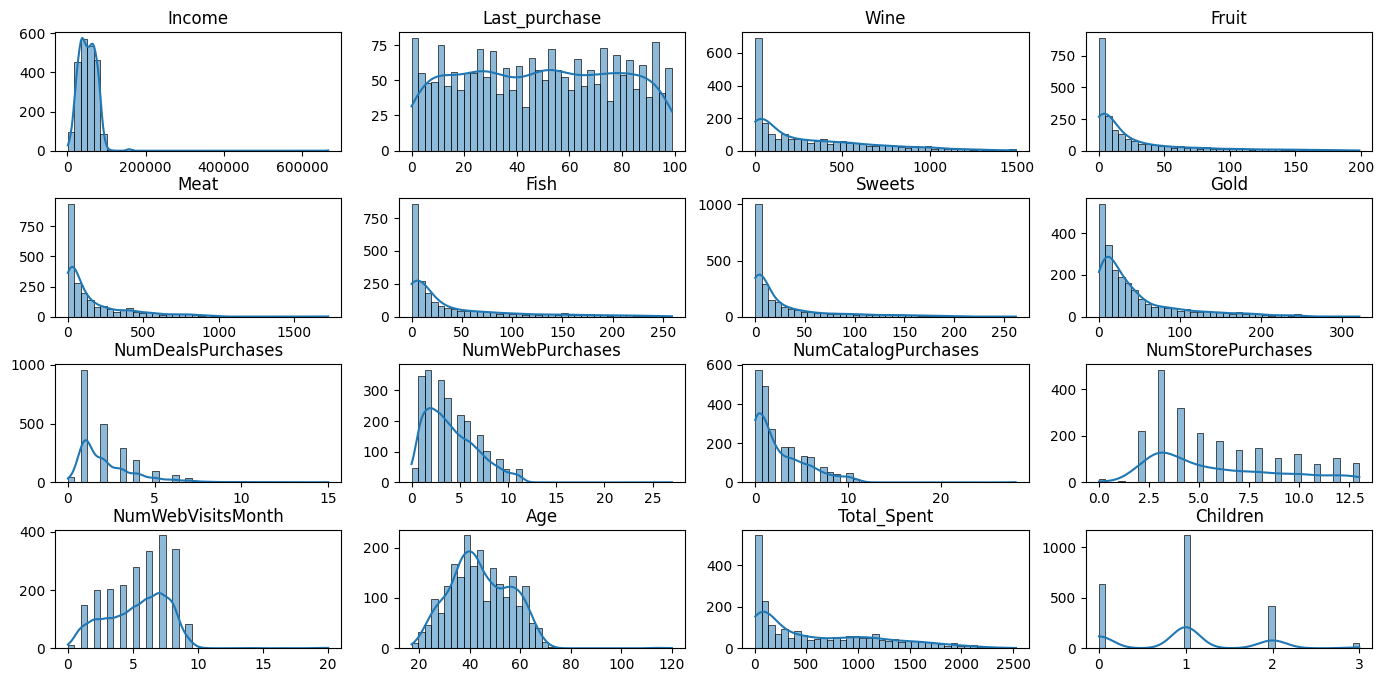

In [18]:
#univariate
#Income, Last_purchase, Wine, Fruit, Meat, Fish, Sweets, Gold, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, Age, Total_Spent, Children
fig, axes = plt.subplots(4,4,figsize=(17,8))

for i,feature in enumerate(num_col):
  sns.histplot(df[feature],kde=True,bins=40,ax=axes[i//4,i%4])
  axes[i//4,i%4].set_title(feature)
  axes[i // 4, i % 4].set_xlabel("")
  axes[i // 4, i % 4].set_ylabel("")
plt.subplots_adjust(hspace=0.4)

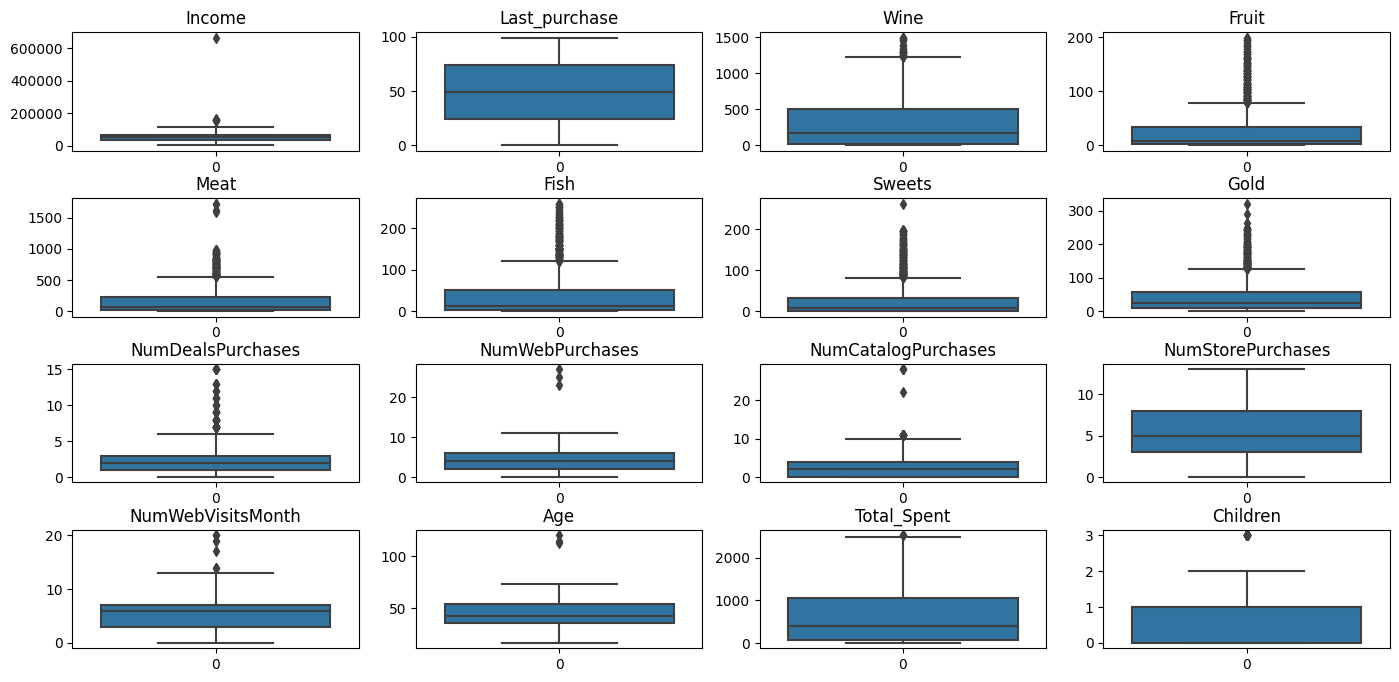

In [19]:
fig, axes = plt.subplots(4,4,figsize=(17,8))

for i,feature in enumerate(num_col):
  sns.boxplot(df[feature],ax=axes[i//4,i%4])
  axes[i//4,i%4].set_title(feature)
  axes[i // 4, i % 4].set_xlabel("")
  axes[i // 4, i % 4].set_ylabel("")
plt.subplots_adjust(hspace=0.4)

From the above plots we can clearly see that their are outliers for all of the columns except Last_purchase and NumStorePurchases

(array([0, 1, 2]),
 [Text(0, 0, 'Graduate'),
  Text(1, 0, 'PostGraduate'),
  Text(2, 0, 'UnderGraduate')])

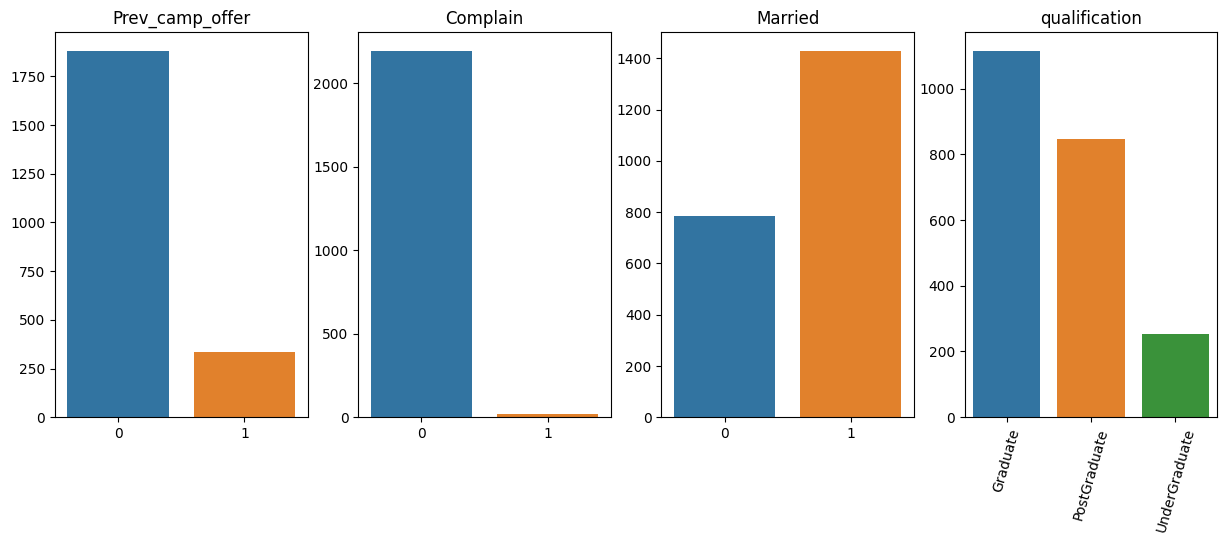

In [20]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
for i,feature in enumerate(cat_col):
  sns.countplot(x = feature, data = df,orient='v',ax = axes[i])
  axes[i].set_ylabel("")
  axes[i].set_title(feature)
  axes[i].set_xlabel("")
plt.xticks(rotation=74)

**Feature Engineering**

In [21]:
# outlier replacement
def replace_outliers(x, q1, q3):
    iqr = q3-q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    for col in num_col:
        for idx in x.index:
            if x.loc[idx, col] > upper_bound[col]:
                x.loc[idx, col] = upper_bound[col]

    return x

df = replace_outliers(df, df.quantile(0.25), df.quantile(0.75))

<ipython-input-21-8e2ca6108070>:14: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = replace_outliers(df, df.quantile(0.25), df.quantile(0.75))


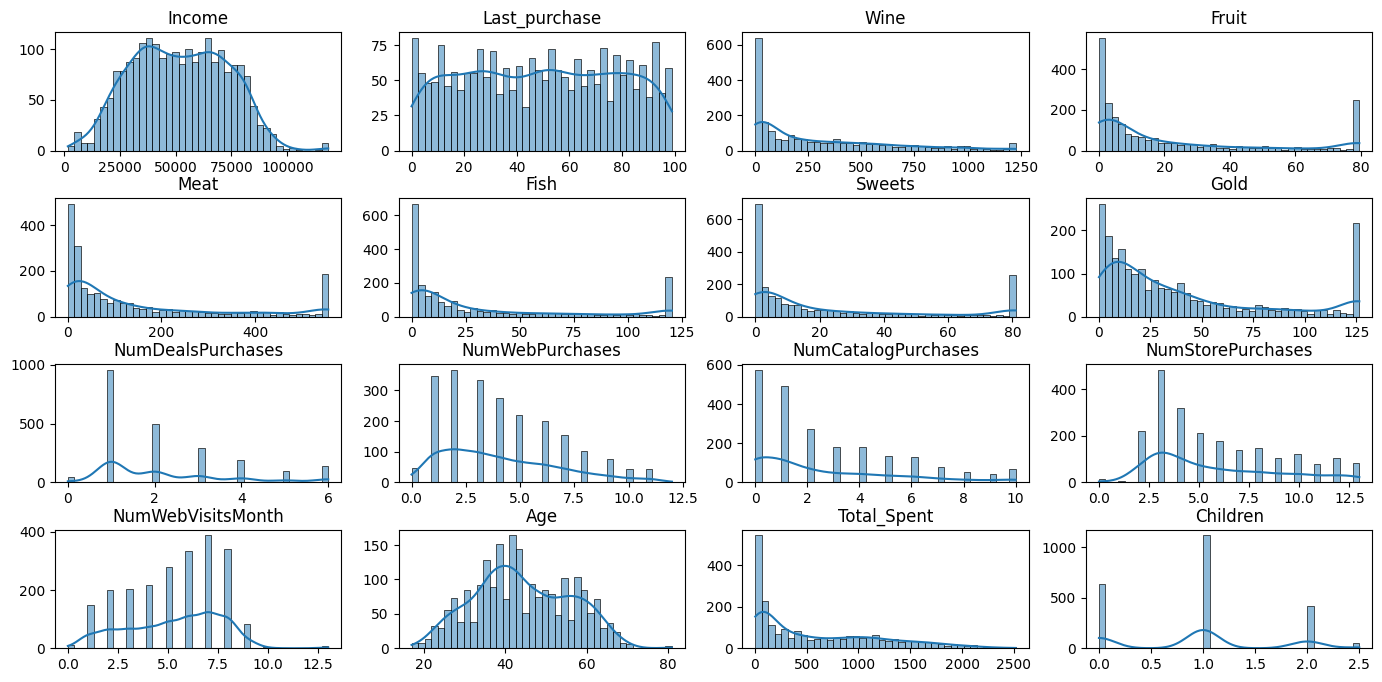

In [22]:
#univariate
#Income, Last_purchase, Wine, Fruit, Meat, Fish, Sweets, Gold, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, Age, Total_Spent, Children
fig, axes = plt.subplots(4,4,figsize=(17,8))

for i,feature in enumerate(num_col):
  sns.histplot(df[feature],kde=True,bins=40,ax=axes[i//4,i%4])
  axes[i//4,i%4].set_title(feature)
  axes[i // 4, i % 4].set_xlabel("")
  axes[i // 4, i % 4].set_ylabel("")
plt.subplots_adjust(hspace=0.4)

In [23]:
from sklearn import set_config
set_config(display='diagram')
#scaling
trf1 = ColumnTransformer([('scale',StandardScaler(),num_col)
],remainder='passthrough')
trf1.fit(df)
df2=trf1.transform(df)


In [24]:
#transforming
trf2 = ColumnTransformer([('Power',PowerTransformer(),list(range(len(num_col)-1)))
],remainder='passthrough')
trf2.fit(df2)
df3 = trf2.transform(df2)

In [25]:
#one hot encoding
trf3 = ColumnTransformer([('ohe',OneHotEncoder(sparse_output = False, drop ='first'),[len(df.columns)-1])],remainder='passthrough')
trf3.fit(df2)
df4 = trf3.transform(df2)

**Model Training, Evaluation and Selection**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

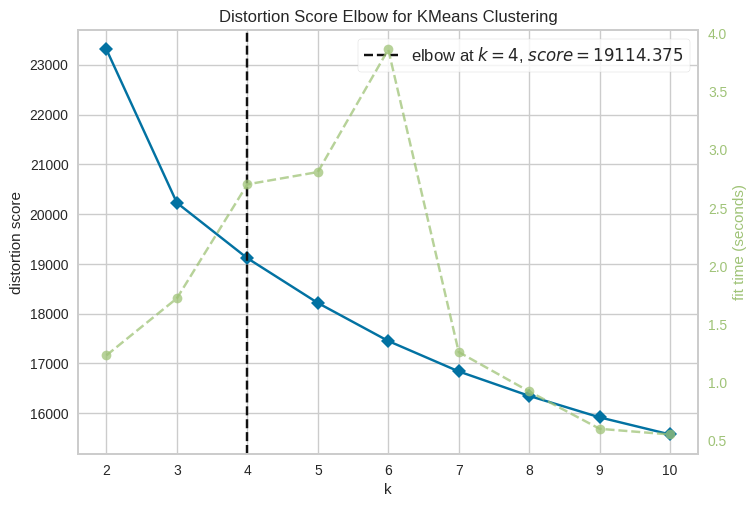

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
#Kmeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

elbow_m = KElbowVisualizer(KMeans())
elbow_m.fit(df4)
elbow_m.show()

In [24]:
kmeans = KMeans(n_clusters=4,init='k-means++',random_state=42)
y_predict = kmeans.fit_predict(df4)
df['Cluster'] = y_predict
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Income,Last_purchase,Wine,Fruit,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Prev_camp_offer,Complain,Age,Total_Spent,Children,Married,qualification,Cluster
0,84835.0,0,189.0,79.5,379.0,111.0,81,126.5,1,4,4,6,1,1,0,43,1190.0,0.0,0,Graduate,1
1,57091.0,0,464.0,5.0,64.0,7.0,0,37.0,1,7,3,7,5,1,0,52,577.0,0.0,0,Graduate,0
2,67267.0,0,134.0,11.0,59.0,15.0,2,30.0,1,3,2,5,2,0,0,55,251.0,1.0,1,Graduate,2
3,32474.0,0,10.0,0.0,1.0,0.0,0,0.0,1,1,0,2,7,0,0,46,11.0,2.0,1,Graduate,2
4,21474.0,0,6.0,16.0,24.0,11.0,0,34.0,2,3,1,2,7,1,0,24,91.0,1.0,0,Graduate,2


In [25]:
kmean_score = silhouette_score(df4,y_predict)
kmean_score

0.1943340855683529

In [27]:
#Kmeans using PCA

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2,random_state=42,whiten=True)
df_pca = pca.fit_transform(df4)
df_pca[0]

array([ 1.55229474, -1.33174911])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

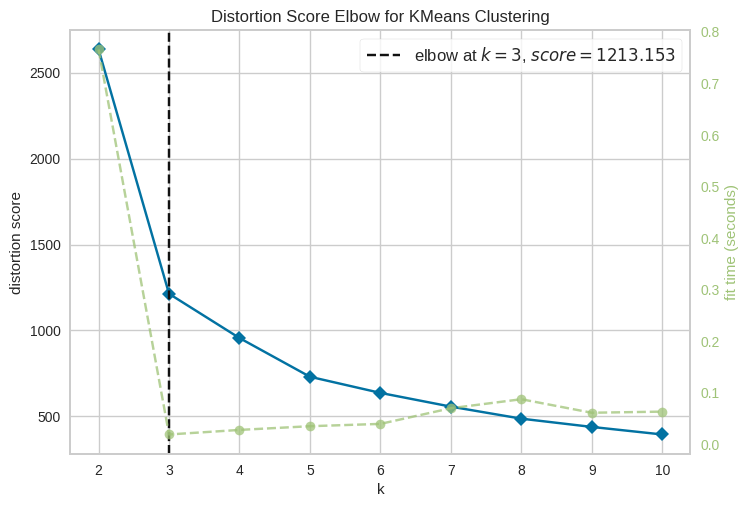

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
elbow_m = KElbowVisualizer(KMeans())
elbow_m.fit(df_pca)
elbow_m.show()

In [29]:
kmeans = KMeans(n_clusters=3,init='k-means++',random_state=42)
y_predict2 = kmeans.fit_predict(df_pca)
df['Cluster'] = y_predict2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
pca_kmean_score = silhouette_score(df_pca,y_predict2)
pca_kmean_score

0.523885286235711

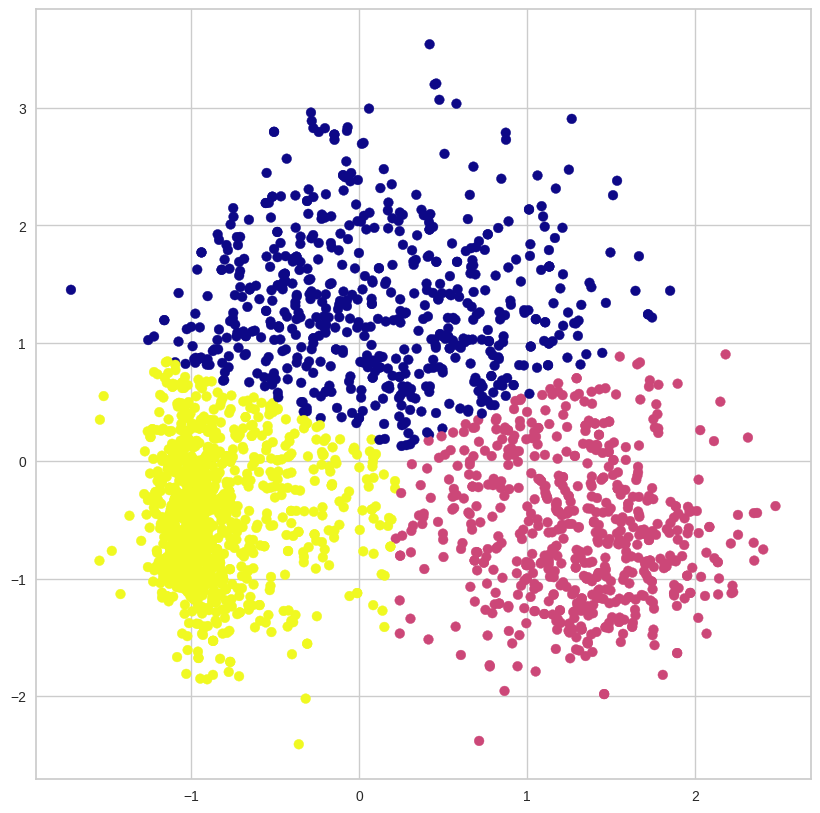

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(df_pca[:,0],df_pca[:,1],c=y_predict2,cmap ='plasma')
plt.show()

In [234]:
#Agglomerative

In [254]:
import scipy.cluster.hierarchy as shc

In [381]:
pca = PCA(n_components=2,random_state=42,whiten=True)
df_pca2 = pca.fit_transform(df4)

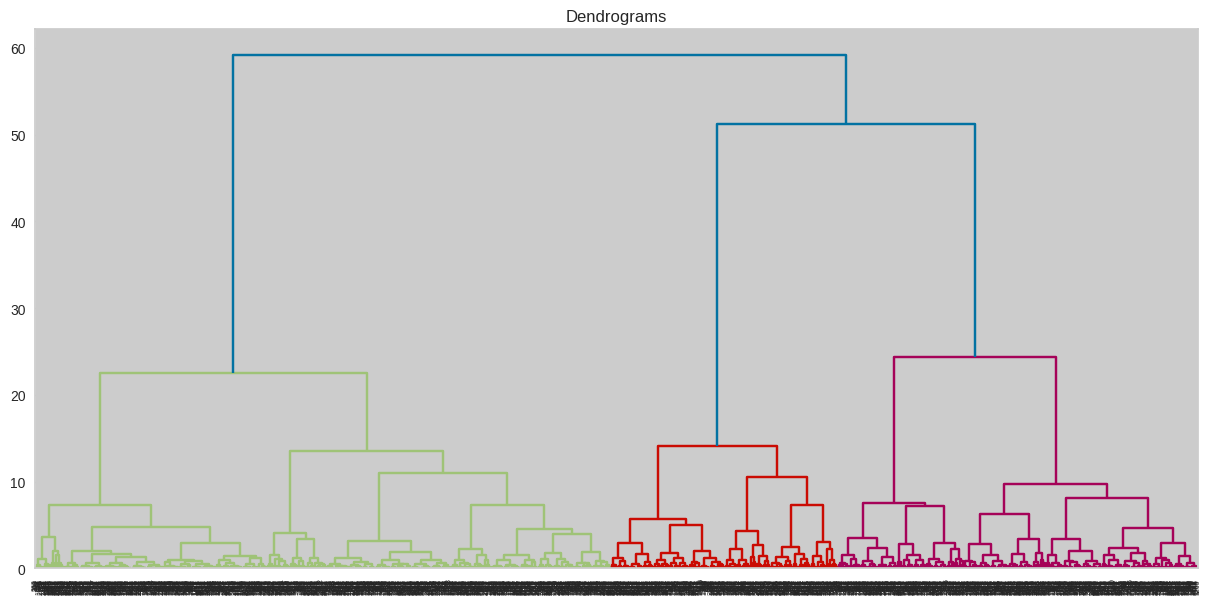

In [303]:
plt.figure(figsize=(15, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df_pca2, method='ward', metric='euclidean'))

In [350]:
from sklearn.cluster import AgglomerativeClustering

In [407]:
ac = AgglomerativeClustering(n_clusters=3,metric='euclidean',linkage='ward')
y_predict3 = ac.fit_predict(df_pca2)

In [408]:
agg_score = silhouette_score(df_pca2,y_predict3)
agg_score

0.49292200427161564

In [29]:
#DBSCAN

In [308]:
from sklearn.cluster import DBSCAN

In [344]:
db = DBSCAN(eps = 0.0125, min_samples = 1)
y_predict4 = db.fit_predict(df4)

In [345]:
dbscore = silhouette_score(df4,y_predict4)
dbscore

0.16425992545144166

In [370]:
#HyperParameter tuning
from sklearn.model_selection import GridSearchCV
params = {
    "n_clusters" : [2,3,4,5,6],
    "metric" : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
    'linkage' : ['ward', 'complete', 'average', 'single']
}

def silhouette_scorer(estimator,X):
    score = silhouette_score(X, estimator.labels_)
    return score

grid_search = GridSearchCV(AgglomerativeClustering(),param_grid=params,scoring=silhouette_scorer,cv=5)

In [404]:
grid_search.fit(df_pca2)
print(grid_search.best_params_)

Streaming output truncated to the last 5000 lines.
    score = silhouette_score(X, estimator.labels_)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_unsupervised.py", line 117, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_unsupervised.py", line 212, in silhouette_samples
    X, labels = check_X_y(X, labels, accept_sparse=["csc", "csr"])
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1124, in check_X_y
    check_consistent_length(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 397, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [443, 1773]

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-te

{'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}


In [431]:
df.columns

Index(['Income', 'Last_purchase', 'Wine', 'Fruit', 'Meat', 'Fish', 'Sweets',
       'Gold', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Prev_camp_offer', 'Complain',
       'Age', 'Total_Spent', 'Children', 'Married', 'qualification',
       'Cluster'],
      dtype='object')

In [436]:
cat_col

['Prev_camp_offer', 'Complain', 'Married', 'qualification']

cluster questions-


1.   Clusters number split
2.   Income expense EDA
3.   Wine, Fruit, Meat, Fish, Sweets, Gold based expense multi bar plot
4.   Last Purchase, NumDealsPurch, NumWebPurch, NumCatalogPurch, NumStorePurch, NumWebVisit - boxenplot
5.    Cat col - Prev_camp_offer,Complain, Married, qualification, Children - bar plots.
6.   Age scatter plot








<Axes: xlabel='Cluster', ylabel='count'>

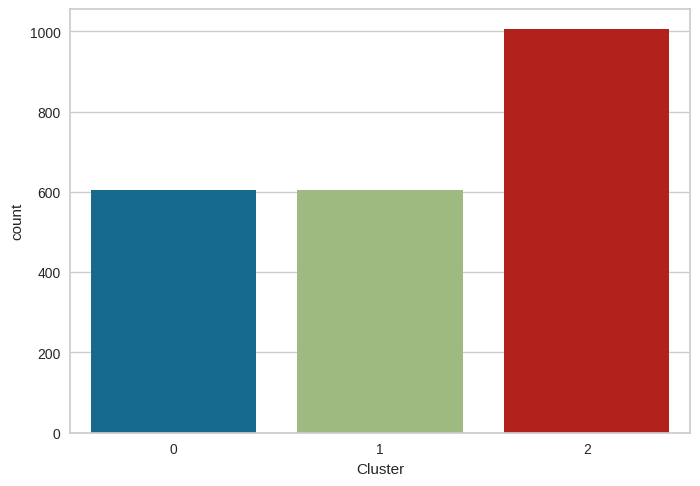

In [32]:
sns.countplot(x=df['Cluster'])

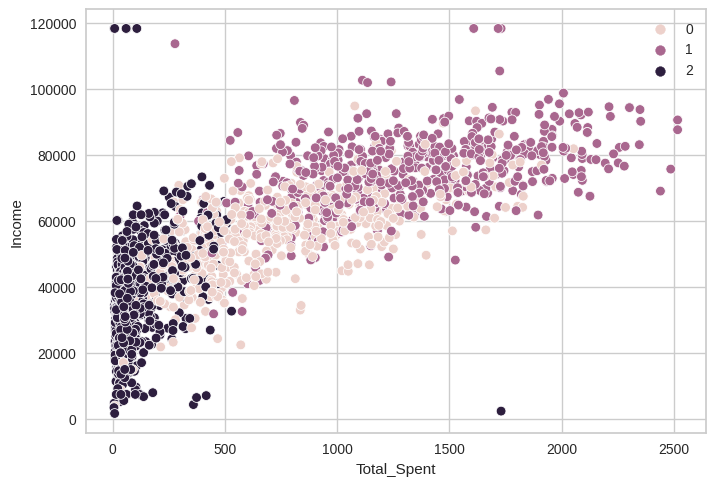

In [33]:
plt = sns.scatterplot(data=df,x=df['Total_Spent'],y=df['Income'],hue=df['Cluster'])
plt.legend()

In [44]:
l = pd.DataFrame(index=['Wine','Fruit','Meat','Fish','Sweets','Gold'],columns=[0,1,2])
for cluster in range(3):
    cluster_data = df[df.iloc[:, -1] == cluster]
    bar = np.sum(cluster_data.iloc[:, 2:8], axis=0)
    bar /= np.sum(bar)
    l[cluster] = bar

#plt.figure(figsize=(15,10))

plt.bar(list(range(3)),l.iloc[0,:],width=0.5,label='Wine')
plt.bar(list(range(3)),l.iloc[1,:],bottom=l.iloc[0,:],label='Fruit',width=0.5)
plt.bar(list(range(3)),l.iloc[2,:],bottom=l.iloc[1,:]+l.iloc[0,:],label='Meat',width=0.5)
plt.bar(list(range(3)),l.iloc[3,:],bottom=l.iloc[2,:]+l.iloc[1,:]+l.iloc[0,:],label='Fish',width=0.5)
plt.bar(list(range(3)),l.iloc[4,:],bottom=l.iloc[3,:]+l.iloc[2,:]+l.iloc[1,:]+l.iloc[0,:],label='Sweets',width=0.5)
plt.bar(list(range(3)),l.iloc[5,:],bottom=l.iloc[4,:]+l.iloc[3,:]+l.iloc[2,:]+l.iloc[1,:]+l.iloc[0,:],label='Gold',width=0.5)

plt.legend()

plt.show()

AttributeError: ignored

In [40]:
fig , axes = plt.subplots(2,3,figsize=(10,10))
sns.boxenplot(x=df['Cluster'],y=df['NumDealsPurchases'],ax=axes[0][0])
sns.boxenplot(x=df['Cluster'],y=df['NumWebPurchases'],ax=axes[0][1])
sns.boxenplot(x=df['Cluster'],y=df['NumCatalogPurchases'],ax=axes[0][2])
sns.boxenplot(x=df['Cluster'],y=df['NumStorePurchases'],ax=axes[1][0])
sns.boxenplot(x=df['Cluster'],y=df['NumWebVisitsMonth'],ax=axes[1][1])
sns.boxenplot(x=df['Cluster'],y=df['Last_purchase'],ax=axes[1][2])

AttributeError: ignored

In [41]:
df_subset = df.groupby('Prev_camp_offer')["Cluster"].value_counts()
df_subset

Prev_camp_offer  Cluster
0                2          929
                 0          507
                 1          447
1                1          158
                 0           99
                 2           76
Name: Cluster, dtype: int64

In [45]:
axis_y = "percentage of customers"
df_subset = df.groupby('Prev_camp_offer')["Cluster"].value_counts() / len(df)
#df_subset = df_subset.to_frame().rename({"Prev_camp_offer": axis_y}, axis=1).reset_index()

df_subset

Prev_camp_offer  Cluster
0                2          0.419224
                 0          0.228791
                 1          0.201715
1                1          0.071300
                 0          0.044675
                 2          0.034296
Name: Cluster, dtype: float64

ValueError: ignored

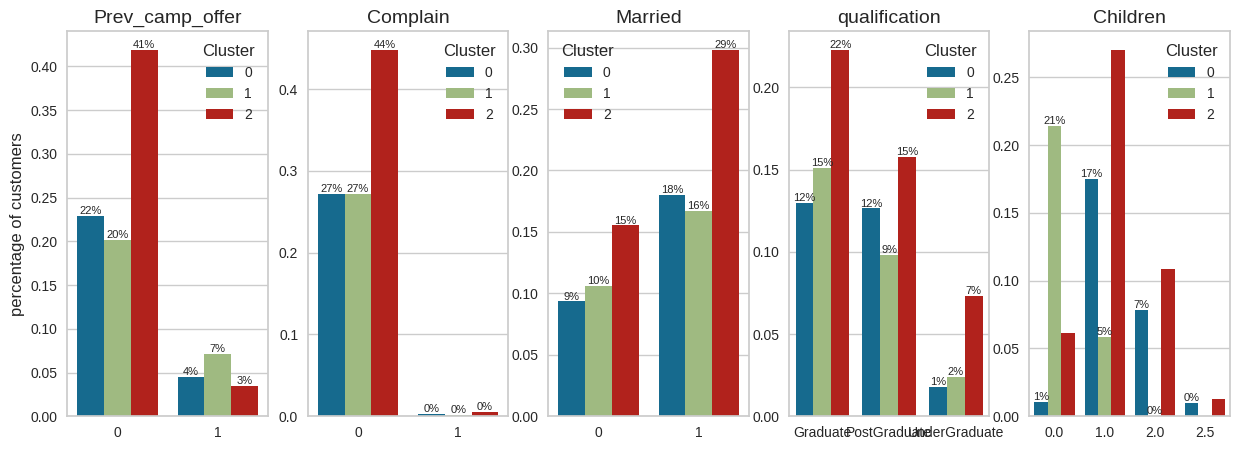

In [552]:
#Prev_camp_offer,Complain, Married, qualification, Children - bar plots.


def plot_cluster_by_feature1D(df, features):
    size = len(features)
    fig, axes = plt.subplots(1, size , figsize=(15, 5))
    axis_y = "percentage of customers"

    for i, feature in enumerate(features):
        df_subset = df.groupby(feature)["Cluster"].value_counts() / len(df)
        df_subset = df_subset.to_frame().rename({"Cluster": axis_y}, axis=1).reset_index()
        sns.barplot(x=feature, y=axis_y, hue="Cluster", data=df_subset, ax=axes[i])
        if i % size == 0:
            axes[i].set_ylabel(axis_y, fontsize=12)
        else:
            axes[i].set_ylabel("")

        # Set the title above the graph
        axes[i].set_title(feature, fontsize=14)
        axes[i].set_xlabel("")

        # Add the number of values in the bar
        for bar in axes[i].patches:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2, height, str(int(height * 100)) + "%", ha="center", va="bottom", size=8,wrap=True)

    plt.xticks(rotation = 75)
    plt.suptitle("Cluster Rate by Feature", fontsize=16)
    plt.show()


features = ["Prev_camp_offer","Complain", "Married", "qualification", "Children"]
plot_cluster_by_feature1D(df, features)

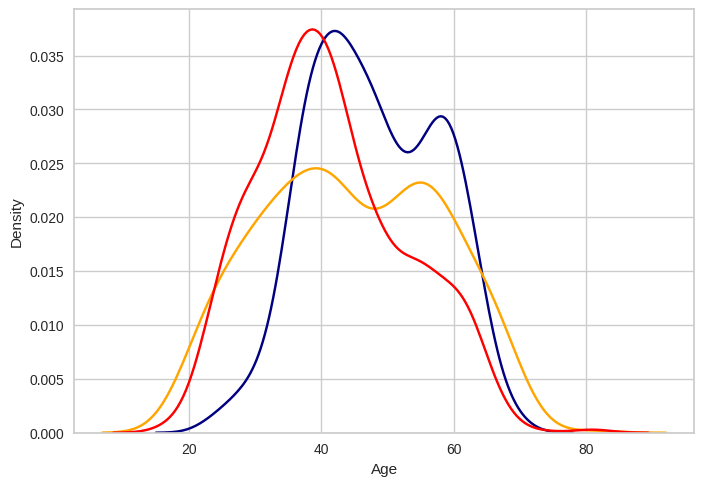

In [46]:
sns.kdeplot(df[df['Cluster'] == 0]['Age'],color= 'navy', label= 'Churn: 0')
sns.kdeplot(df[df['Cluster'] == 1]["Age"],color= 'orange', label= 'Churn: 1')
sns.kdeplot(df[df['Cluster'] == 2]["Age"],color= 'red', label= 'Churn: 2')

plt.legend()

**Model Deployment**

In [52]:
X = df.drop(['Cluster'],axis=1)
y = df['Cluster']

In [59]:
trf = ColumnTransformer([
    ('ohe',OneHotEncoder(sparse_output = False, drop ='first'),[len(X.columns)-1])
],remainder='passthrough')

X2 = trf.fit_transform(X)

x_train,x_test,y_train,y_test = train_test_split(X2,y,test_size=0.3)

In [73]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
xgb.fit(x_train,y_train)
y_pred = xgb.predict(x_test)

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       179
           1       0.99      0.97      0.98       186
           2       0.97      0.99      0.98       300

    accuracy                           0.97       665
   macro avg       0.97      0.97      0.97       665
weighted avg       0.97      0.97      0.97       665



In [80]:
pipe = Pipeline([
    ('trf',trf),
    ('xgb',xgb)
])
pipe

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [19])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               featur...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [82]:
import pickle
filename = 'ohe_xgb.sav'
pickle.dump(pipe, open(filename, 'wb'))


In [84]:
import os
from google.colab import files

# Download the file
files.download('ohe_xgb.sav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>